In [2]:
from legend_plot_style import LEGENDPlotStyle as lps
lps.use("legend_talks")
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import math
from collections import Counter
from scipy.interpolate import interp1d

file_path = '/home/eric/sim/WWLegend/Archive/Neutrontaggerruns/'
""" Amount is required to know how many entries belong to each neutron. 
    nPMMA is an array where each entry says how many photon timestamp belong to that neutron.
    Time for the time entries. Each entry is one photon timestamp.
    no is required to match Shower IDs, Identifier for something else.
    Read in 2 different setups to compare!"""
nSetup1 = np.loadtxt(file_path + "Warwick with ArgonModerator/BaselineWithPMTs/BaselineWithPMTsAmount.csv", dtype=float, delimiter=',', skiprows=5, unpack=True) #first name
timeSetup1, WavelengthsSetup1, PMTIDsSetup1  = np.loadtxt(file_path + "Warwick with ArgonModerator/BaselineWithPMTs/BaselineWithPMTsTimes.csv", dtype=float, skiprows=5, delimiter=',', unpack=True)

#nPMMAFoil = np.loadtxt(file_path + "Warwick with ArgonModerator/Baseline/BaselineWithPMTQEAmount.csv", dtype=float, delimiter=',', skiprows=5, unpack=True) #second name
#timePMMAFoil, WavelengthsPMMAFoil = np.loadtxt(file_path + "Warwick with ArgonModerator/Baseline/BaselineWithPMTQETimes.csv", dtype=float, skiprows=5, delimiter=',', unpack=True)

#nPMMA_Allmuons = np.loadtxt(file_path + "Warwick without ArgonModerator all events/Foil Behind PMMA/PMMAAmount.txt", dtype=float, delimiter=',', skiprows=5, unpack=True) #All muons for deadtime
#timePMMA_Allmuons = np.loadtxt(file_path + "Warwick without ArgonModerator all events/Foil Behind PMMA/PMMATimes.txt", dtype=float, skiprows=5, delimiter=',', unpack=True)

""" no carries the id to which shower each neutron belongs. """
noSetup1, x, y, z, ekin, NeutronCaptureTimeDelay = np.loadtxt(file_path + "Warwick with ArgonModerator/ShowerIDs2.txt", dtype=float, delimiter=',', unpack=True) #first name
identifierSetup1, useless, session, session2, bruh, bruh2 = np.loadtxt(file_path + "Warwick with ArgonModerator/PMMARun2.txt", dtype=float, delimiter=',', unpack=True)

no2, x2, y2, z2, ekin2, NeutronCaptureTimeDelay2 = np.loadtxt(file_path + "Warwick with ArgonModerator/ShowerIDs2.txt", dtype=float, delimiter=',', unpack=True) 
identifierPMMA2, useless, session, session2, bruh, bruh2 = np.loadtxt(file_path + "Warwick with ArgonModerator/PMMARun2.txt", dtype=float, delimiter=',', unpack=True) #second name

#no_All, x_All, y_All, z_All, ekin_All, NeutronCaptureTimeDelay_All = np.loadtxt(file_path + "Warwick without ArgonModerator all events/ShowerIDs.txt", dtype=float, delimiter=',', skiprows=1, unpack=True) 
#identifierPMMA_All, useless, session, session2, bruh, bruh2 = np.loadtxt(file_path + "Warwick without ArgonModerator all events/PMMARun.txt", dtype=float, delimiter=',', unpack=True) #All muons for deadtime

name1= "Baseline"  # belongs to "first" read in setup
name2 = "Not yet Implemented" # belongs to "second" read in setup

Function block

In [31]:
def subarray_it_up(n, time, id):
    """ Takes array of number of timestamps per neutron, the timestamps 
        and the array of ids of the corresponding Shower of the neutron. 
        Returns Array where each subarray corresponds to all 
        Timestamps of one Shower. Size should be amount of Showers."""
    unique, counts = np.unique(id, return_counts=True)
    cum_counts = np.cumsum(counts)
    cum_counts = cum_counts.astype(int)
    cum_n = np.cumsum(n)
    cum_n = cum_n.astype(int)
    subarrays = [time[0 if i == 0 else cum_n[(cum_counts[i-1]) - 1]:cum_n[(cum_counts[i])-1]] for i in range(len(counts))]
    return subarrays

def Photons_in_intervall_and_200ns(n,times,startTime,endTime):
    """ Takes the array of photons per Ncapture and counts only those within the time intervall + only those that are within 200ns of the first.
    Returns array of photons within intervall per Ncapture. """
    cum_index = np.cumsum(n)
    cum_index = cum_index.astype(int)
    # Insert 0 as the first starting index
    start_indexes = np.insert(cum_index[:-1], 0, 0)
    end_indexes = cum_index

    # Initialize an array to store the counts
    counts = np.zeros(len(start_indexes), dtype=int)

    for i, (start, end) in enumerate(zip(start_indexes, end_indexes)):
        # Get the times within the interval
        times_within_interval = times[start:end]
        if len(times_within_interval) > 0:
            first = np.min(times_within_interval)
            # Count the values in the time interval
            counts[i] = np.sum(((times_within_interval > startTime) & (times_within_interval < endTime)) & (times_within_interval < (first + 200)))
    return counts

def Single_neutrons_detected(n,PE, size):
    """Takes the array of Photons per NCapture, the x-axis array of PEs and the amount of neutron captures 
        to normalize on (Only water or all?).
        Returns the percentage of NCaptures detected for the given PEs."""
    results_array = np.array([])
    for i in PE:
        num = np.sum(n > i)
        Percentage = num / size
        results_array= np.append(results_array, Percentage)
    return results_array

def remove_nonWater_captures(n,identifier):
    """Takes the array of Photonhits per NC and removes all captures that were not in the water
        according to the identiefier."""
    result = n[(identifier != 4)]
    return result

def histlist(AllShowers, window, timeMax):
    """ Takes whole Shower array and divides each Shower 
        in time windows of size "window" up to timeMax.
        Returns Array with histogram for each Shower
        with window/timeMax bins and max range timeMax."""
    b = int(timeMax/window)
    hists_list = []
    for Shower in AllShowers:
        x, y = np.histogram(Shower, bins=b, range=(0, timeMax))
        hists_list.append(x)
    hists_array = np.array(hists_list)
    return hists_array

def bins_over_thresh(arr, threshold):
    """ Takes single array and a threshold.
        Returns how many entries are above threshold"""
    res = np.sum(arr > threshold)
    return res

def distinguished_neutrons(AllShowers, mult, window, timeMax):
    """ Takes whole Shower array, a given multiplicity, 
        given Amount of PMTs, size of coincidence intervall
        (in ns) and maximum time delay (in ns).
        Returns an array where each entry is the amount of neutrons
        of that Shower that would be detected with these 4 conditions.
    """
    hists_array = histlist(AllShowers, window,timeMax)
    threshold = mult
    results_array = np.array([])
    for i in hists_array:
        results_array = np.append(results_array, bins_over_thresh(i, threshold))
    return results_array


#Returns how many showers have seen more than x neutrons.
def more_than_x_Neutrons(neutrons, x):
    """ Takes array "neutrons" and threshold x.
        Returns the percentage of entries that
        are above threshold."""
    size = np.size(neutrons)
    return (np.sum(neutrons >= x) / size)

#Returns the entire Array for all multiplicitys
def more_than_x_Array(AllShowers, x, multiplicitys):
    """ Takes whole Shower array, neutron threshold x and array of multiplicities.
        Returns an array that has an entry for each multiplicity giving the percentage
        of Showers that would be detected with given multiplicity and neutron threshold.
        Other Parameters (Amount of PMTs, coincidence intervall, max time delay) are 
        hardcoded."""
    results_array = np.array([])
    for i in multiplicitys:
        neutrons = distinguished_neutrons(AllShowers=AllShowers,mult=i, window=200, timeMax=200000)
        results_array = np.append(results_array, more_than_x_Neutrons(neutrons,x))
    return results_array

def sub_neutrons(identifier, sub, id, x):
    """Like subarray_it_up but takes the neutron identifiers and returns the list reduced to showers with >x neutron captures
        Takes the identifier array, the subarray after subarray_it_up and the original shower id array and x"""
    unique, counts = np.unique(id, return_counts=True)
    cum_counts = np.cumsum(counts)
    cum_counts = cum_counts.astype(int)
    subarrays = [identifier[0 if i == 0 else cum_counts[i-1]:cum_counts[i]] for i in range(len(counts))]
    subCaptures=np.array([])

    # Now find out which of these arrays in subID has less than x neutron captures in water. (Meaning less than 50 3,1 or 0)
    for arr in subarrays:
        element_counts = Counter(arr)
        count_of_3 = element_counts[3]
        count_of_1 = element_counts[1]
        count_of_0 = element_counts[0]
        subCaptures = np.append(subCaptures, (count_of_0 + count_of_1 + count_of_3))
    subCaptures = subCaptures.astype(int)
    mask = subCaptures > x
    sub50 = [sub[i] for i in range(len(sub)) if mask[i]]
    return sub50

def average_showers_detected(identifier, sub, id, x, multiplicity, neutronThreshold):
    """Takes the identifer, the subarray after subarray_it_up and the original shower id array, array of x values, multiplicity value for the analysis cut
        and the neutronThreshold for the analysis cut
        returns an array that for each x value has the average percentage of detected showers that have
        at least x captures in water, by given p.e. multiplicity and neutronThreshold"""
    results_array = np.array([])
    for i in x:
        tempArray = sub_neutrons(identifier, sub, id, i)
        neutrons = distinguished_neutrons(AllShowers=tempArray,mult=multiplicity, window=200, timeMax=200000)
        detected = np.sum(neutrons > neutronThreshold)
        percentage = detected / len(tempArray)
        results_array = np.append(results_array,percentage)
    return results_array

In [33]:
#Sort the arrays according to the showers.
SortedTimestampsSetup1 = subarray_it_up(nSetup1, timeSetup1, noSetup1)
SortedPMTIDsSetup1 = subarray_it_up(nSetup1, PMTIDsSetup1, noSetup1) #These are lists where each entry belongs to one shower.

#Has the number of photons within 10-200 us after the muon and within the first 200ns of the first photon (One entry for each neutron)
Photons_inTime200Setup1 = Photons_in_intervall_and_200ns(nSetup1, timeSetup1, 10000, 200000) 

xPEs = np.linspace(1,12,12)
#This array has the % Chance to detect neutrons for each given p.e. requirement
Single_neutrons_detectedSetup1 = Single_neutrons_detected(Photons_inTime200Setup1,xPEs, np.size(Photons_inTime200Setup1))
#Now do the same but normalize only on water captures to get % to see a water capture
Only_WaterSetup1 = remove_nonWater_captures(nSetup1,identifierSetup1)
Single_neutrons_inWater_detectedSetup1 = Single_neutrons_detected(Photons_inTime200Setup1,xPEs, np.size(Only_WaterSetup1))

#Now calculate how many showers would be detected with given muliplicity
multiplicitys = np.linspace(2,10,9)
Detected_ShowersSetup1 = more_than_x_Array(AllShowers = SortedTimestampsSetup1,x=15, multiplicitys = multiplicitys) #15 Neutrons to detect shower

#And now calculate with given requirement of x Captures in water
neutrons_per_shower = np.linspace(2,51,50)
WShowers_detectedSetup1 = average_showers_detected(identifierSetup1, SortedTimestampsSetup1, noSetup1, neutrons_per_shower, 6, 15)

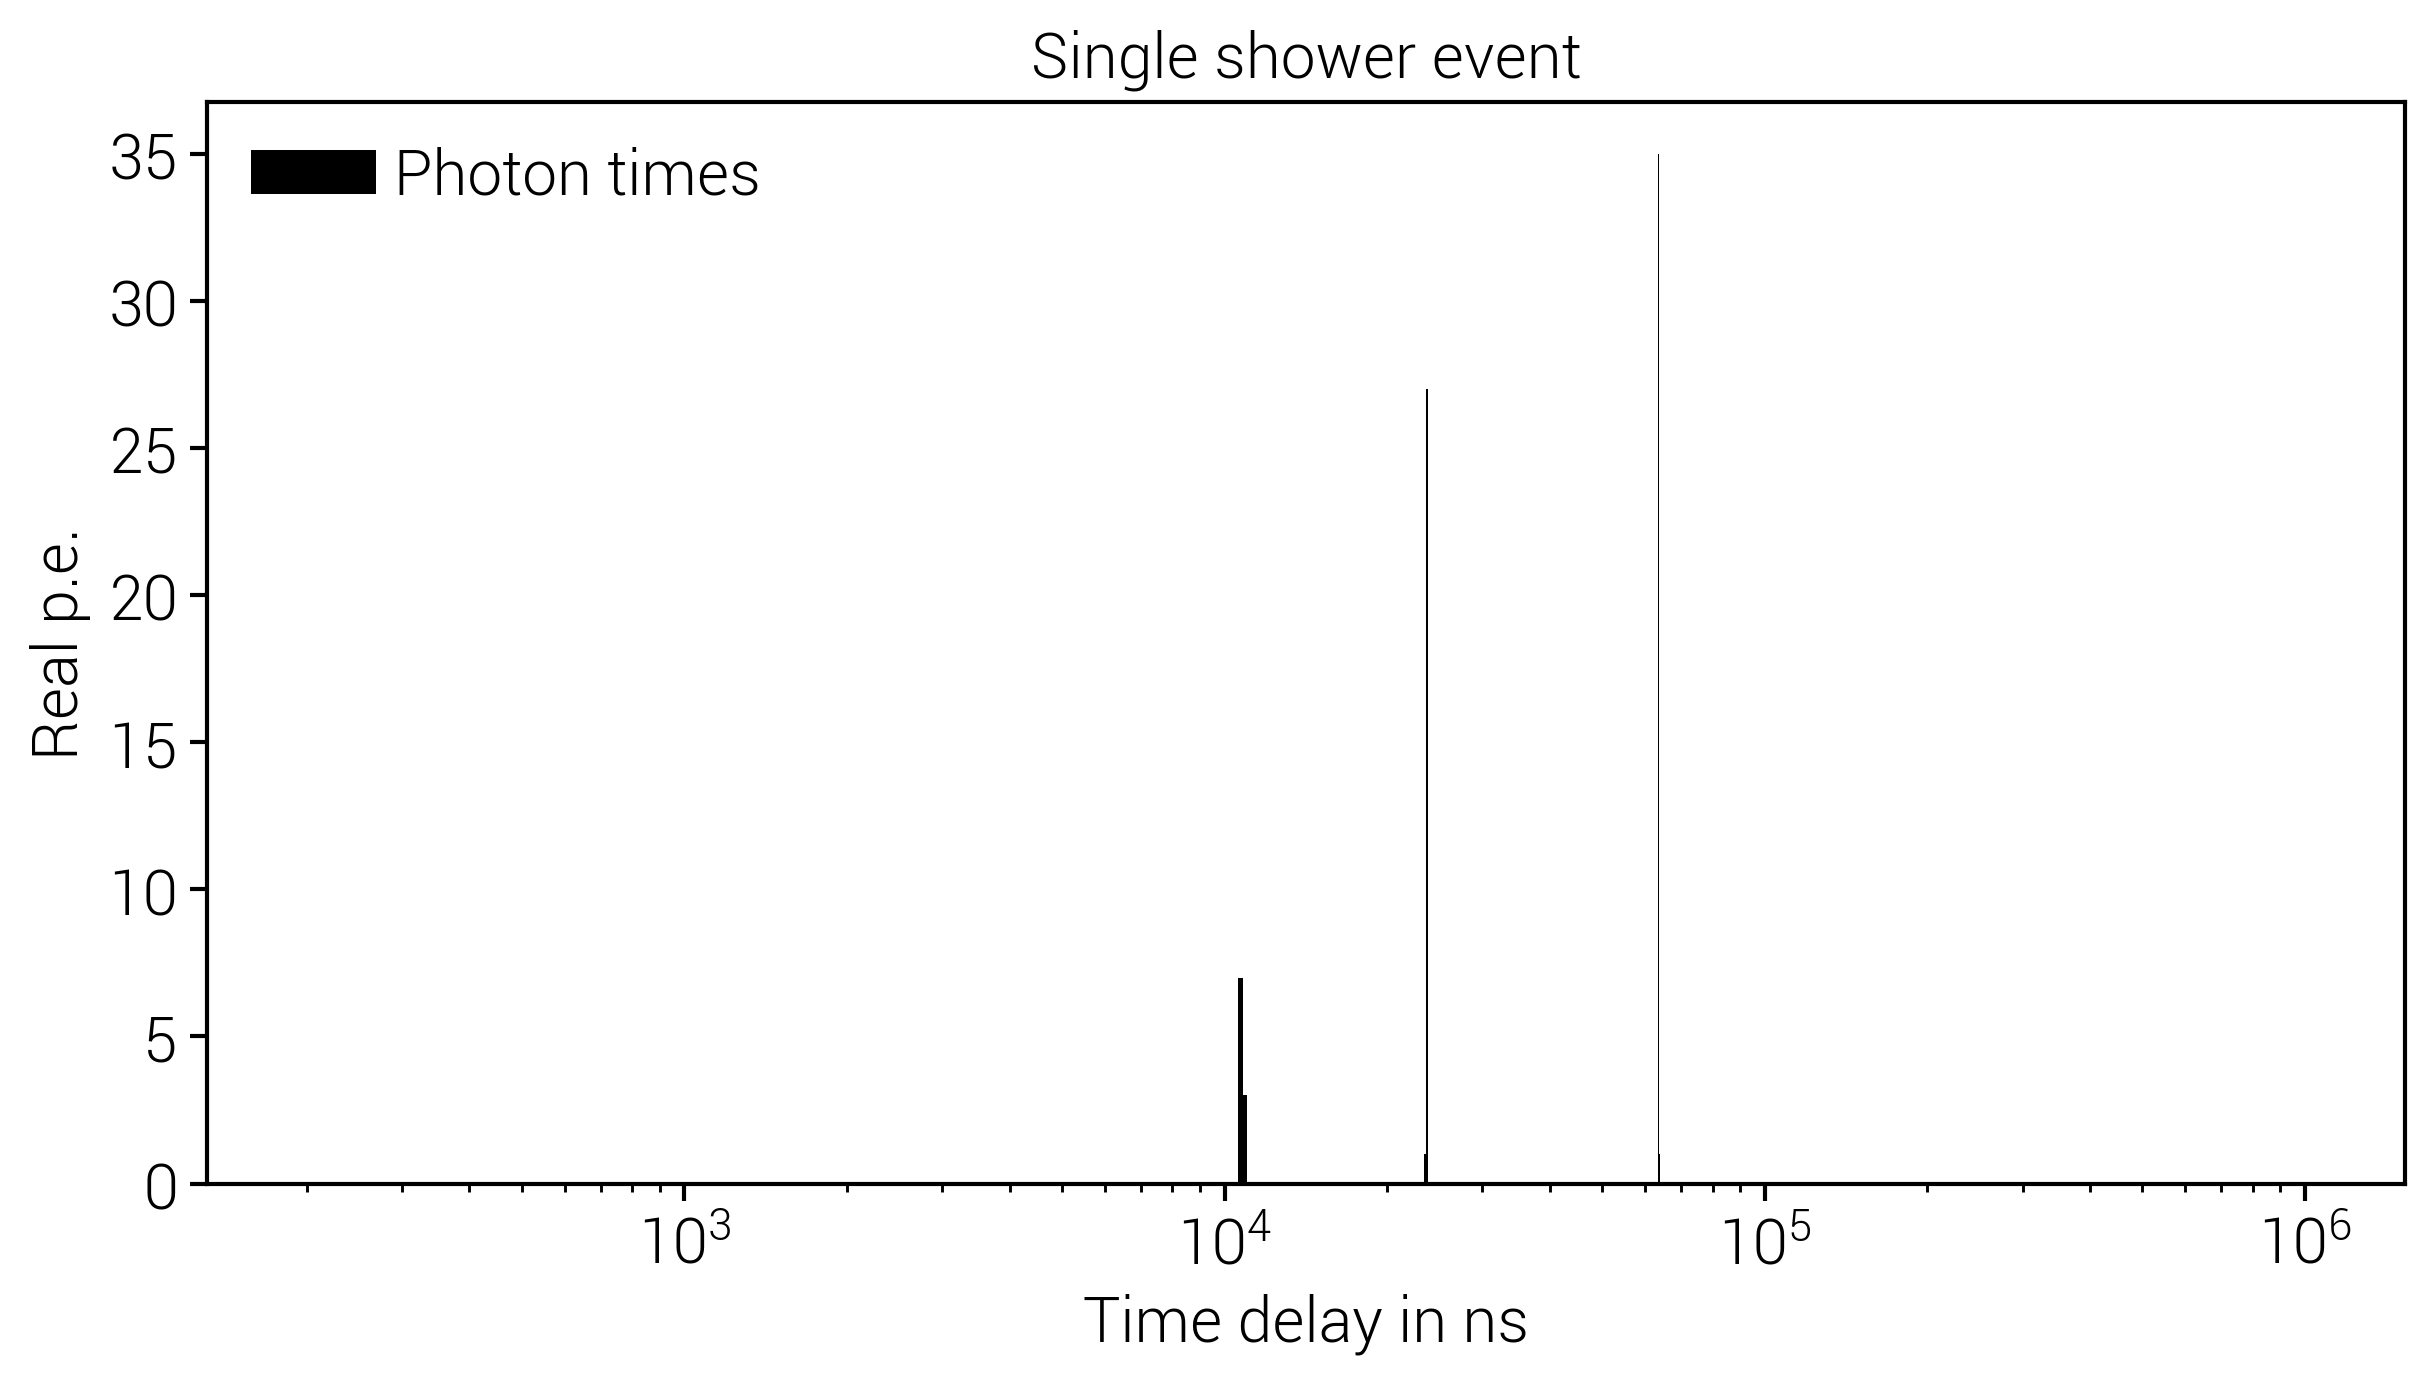

In [21]:
ShowerNumber = 0
fig, ax1 = plt.subplots()
n, bins, patches = ax1.hist(SortedTimestampsSetup1[ShowerNumber], bins = 5000, range = (0, 1000000), label= "Photon times")

ax1.set_xlabel('Time delay in ns')
ax1.set_ylabel('Real p.e.')
ax1.set_title('Single shower event')
ax1.set_xscale('log')
#ax1.set_ylim(bottom=0, top=1000)
#ax1.vlines(Neutrontimes, ymin=0,ymax=np.max(n)*0.75, color=lps.colors["legend_orange"], label = "NeutronCaptures")
ax1.legend(loc= "upper left")
#ax1.grid()
#plt.savefig("/home/eric/sim/WWLegend/Plots/Scintillator/EventNeutronTimesScint.png")
plt.show()

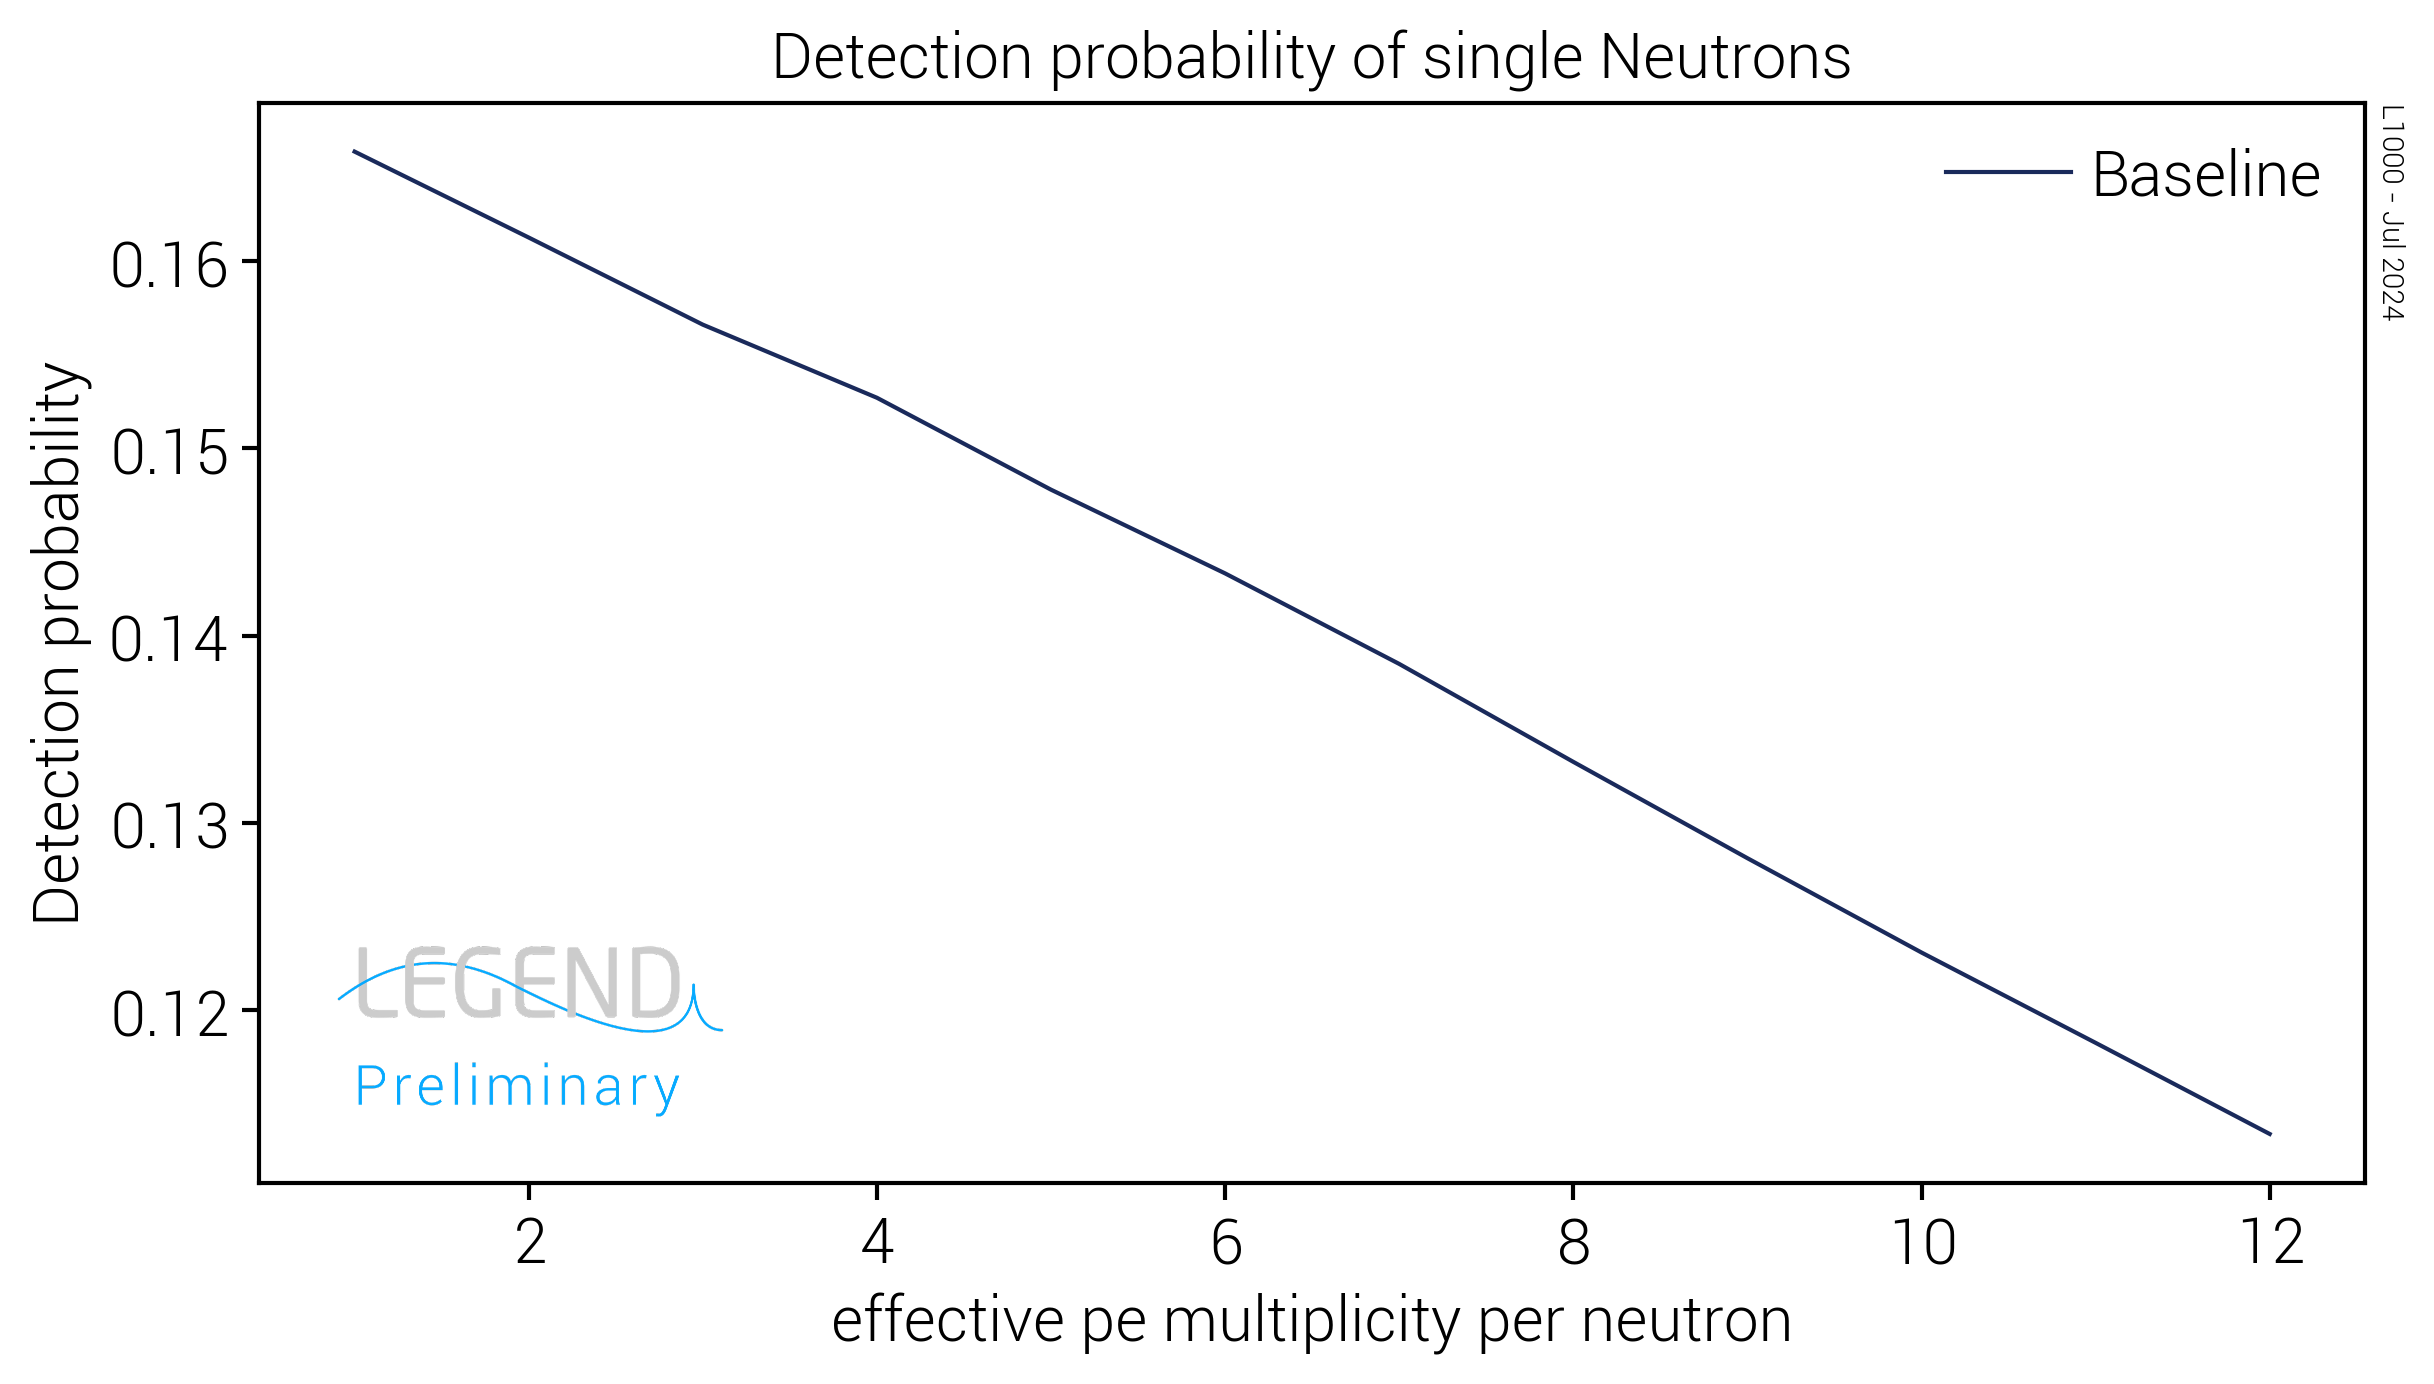

In [22]:
fig, ax1 = plt.subplots()
ax1.plot(xPEs, Single_neutrons_detectedSetup1,  color = lps.colors["legend_darkblue"], label = name1)
#ax1.plot(xPEs, PePerNCaptureSetup2,  color = lps.colors["legend_orange"], label = name2)

ax1.set_xlabel('effective pe multiplicity per neutron')
ax1.set_ylabel('Detection probability')
ax1.set_title('Detection probability of single Neutrons')
#ax1.grid()
ax1.legend(loc='best')
ax1.set_legend_logo(position="lower left")
ax1.set_legend_annotation()
#plt.savefig("/home/eric/sim/WWLegend/Plots/ArgonModvsWithout/SingleDetectionChance.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

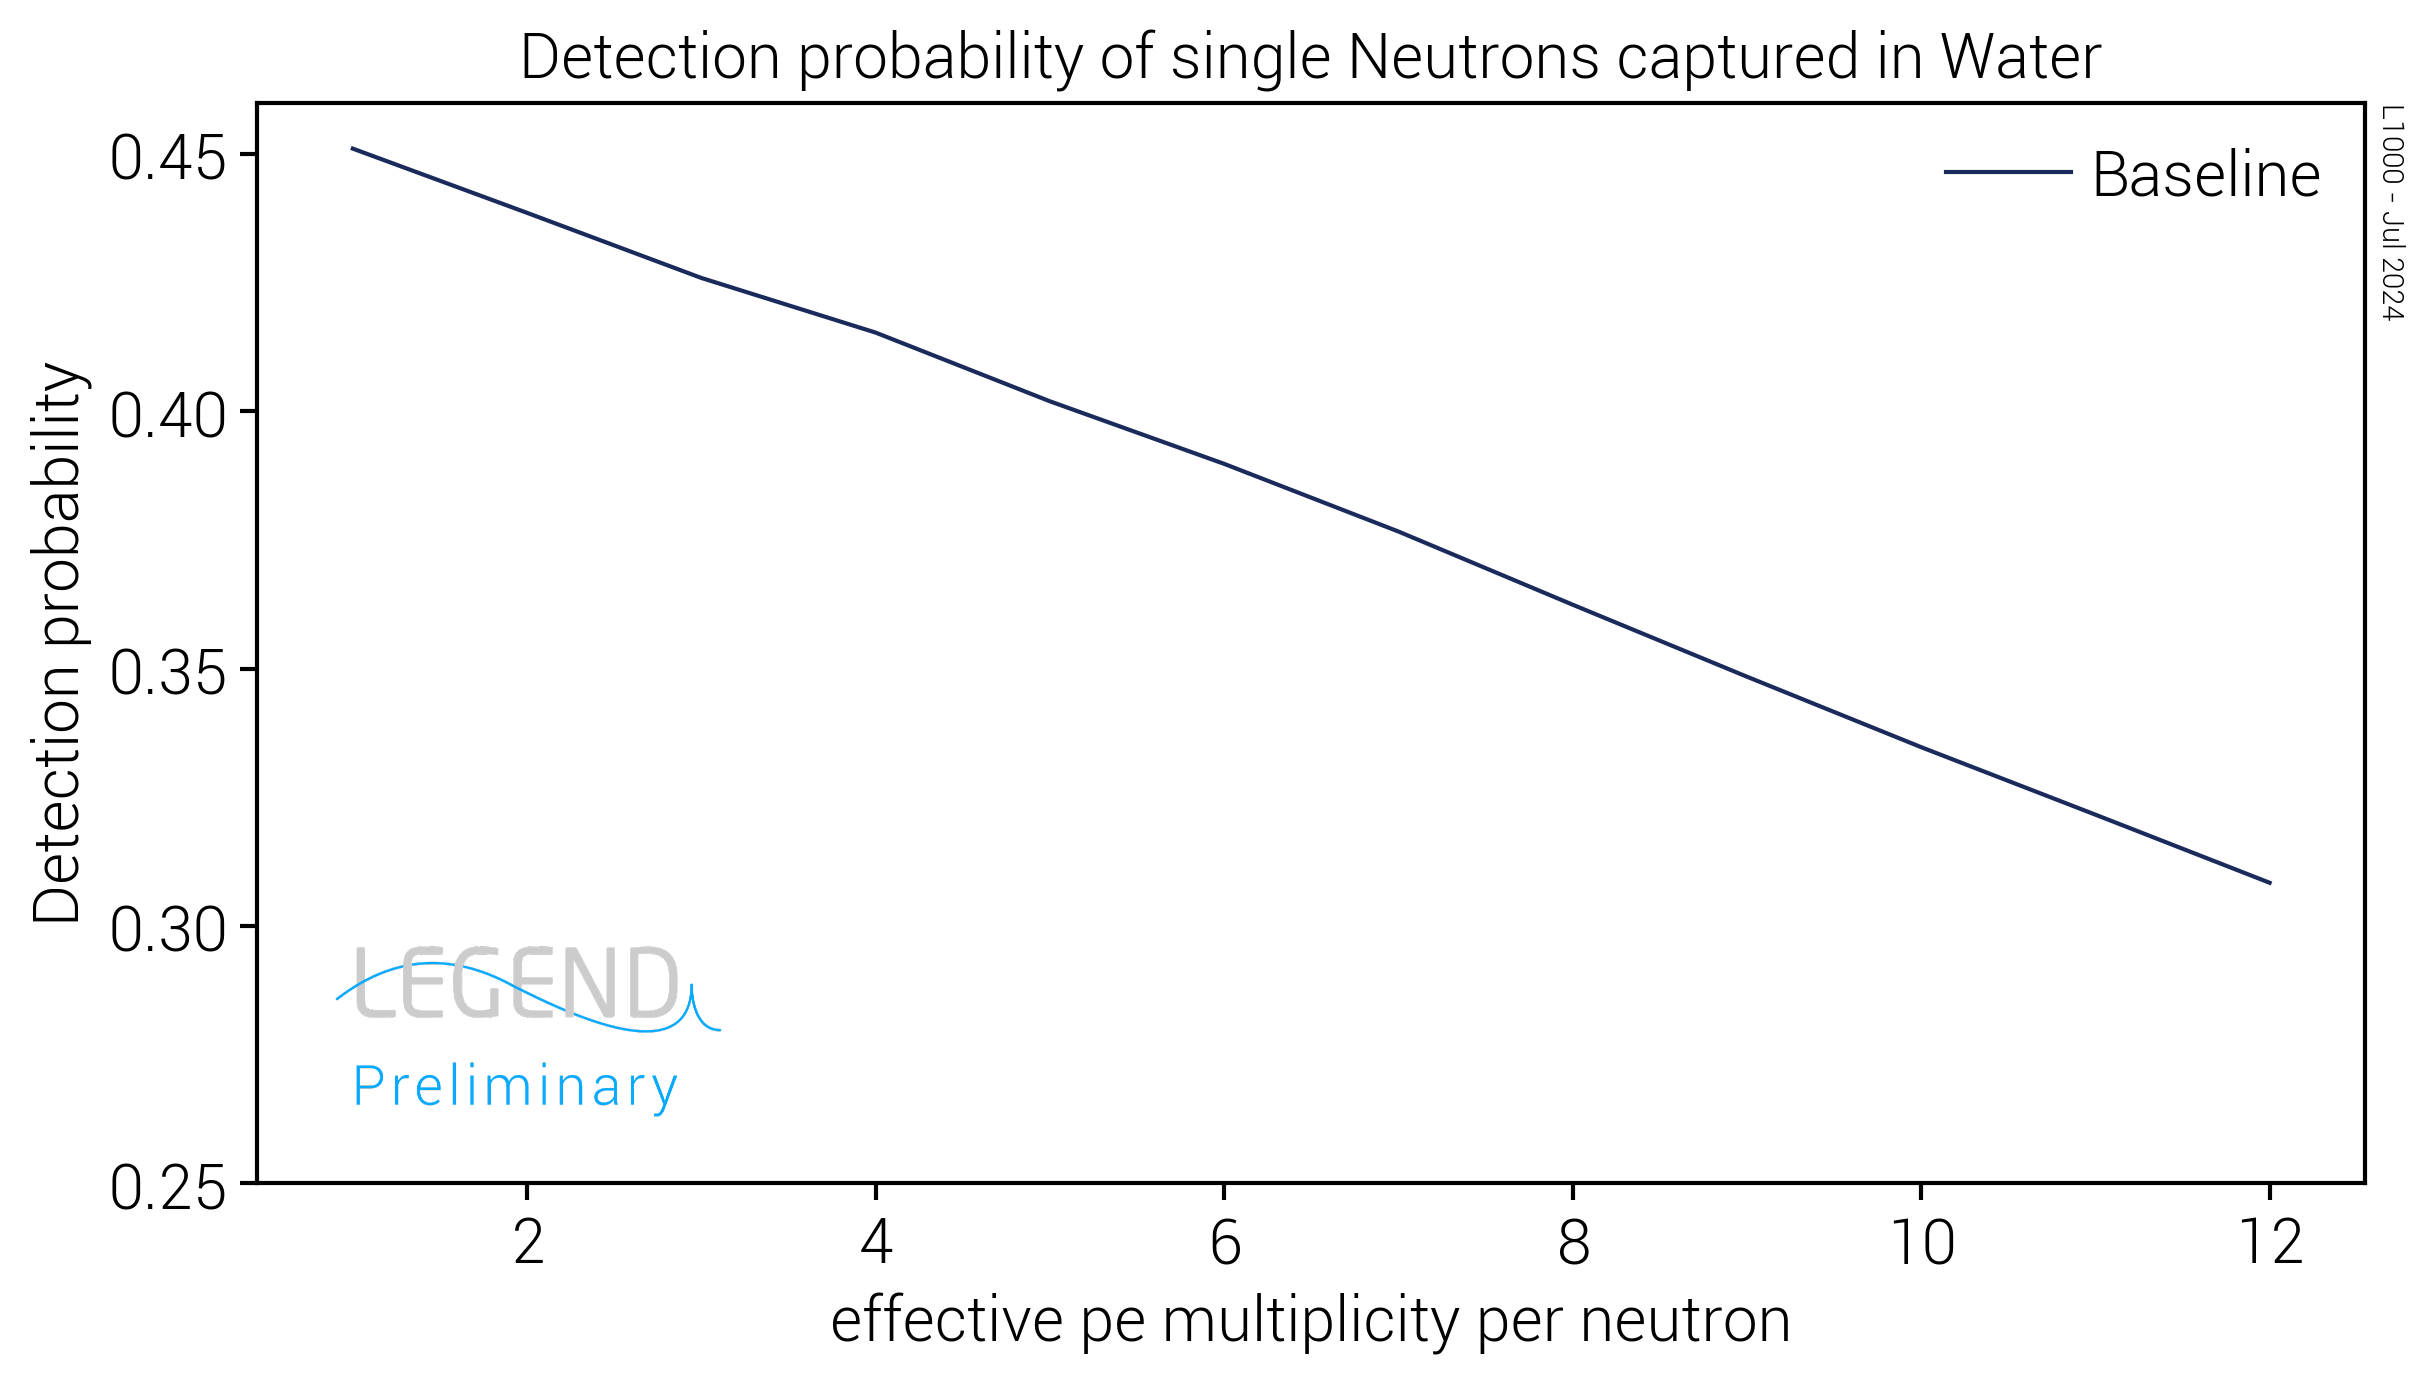

In [38]:
fig, ax1 = plt.subplots()
ax1.plot(xPEs, Single_neutrons_inWater_detectedSetup1,  color = lps.colors["legend_darkblue"], label = name1)
ax1.set_xlabel('effective pe multiplicity per neutron')
ax1.set_ylabel('Detection probability')
ax1.set_title('Detection probability of single Neutrons captured in Water')
#ax1.grid()
ax1.legend(loc='best')
ax1.set_ylim(ymin = 0.25, ymax= 0.46)
ax1.set_legend_logo(position="lower left")
ax1.set_legend_annotation()
#plt.savefig("/home/eric/sim/WWLegend/Plots/PMTsImplemented/SingleDetectionChanceWaterCapturesOnly.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

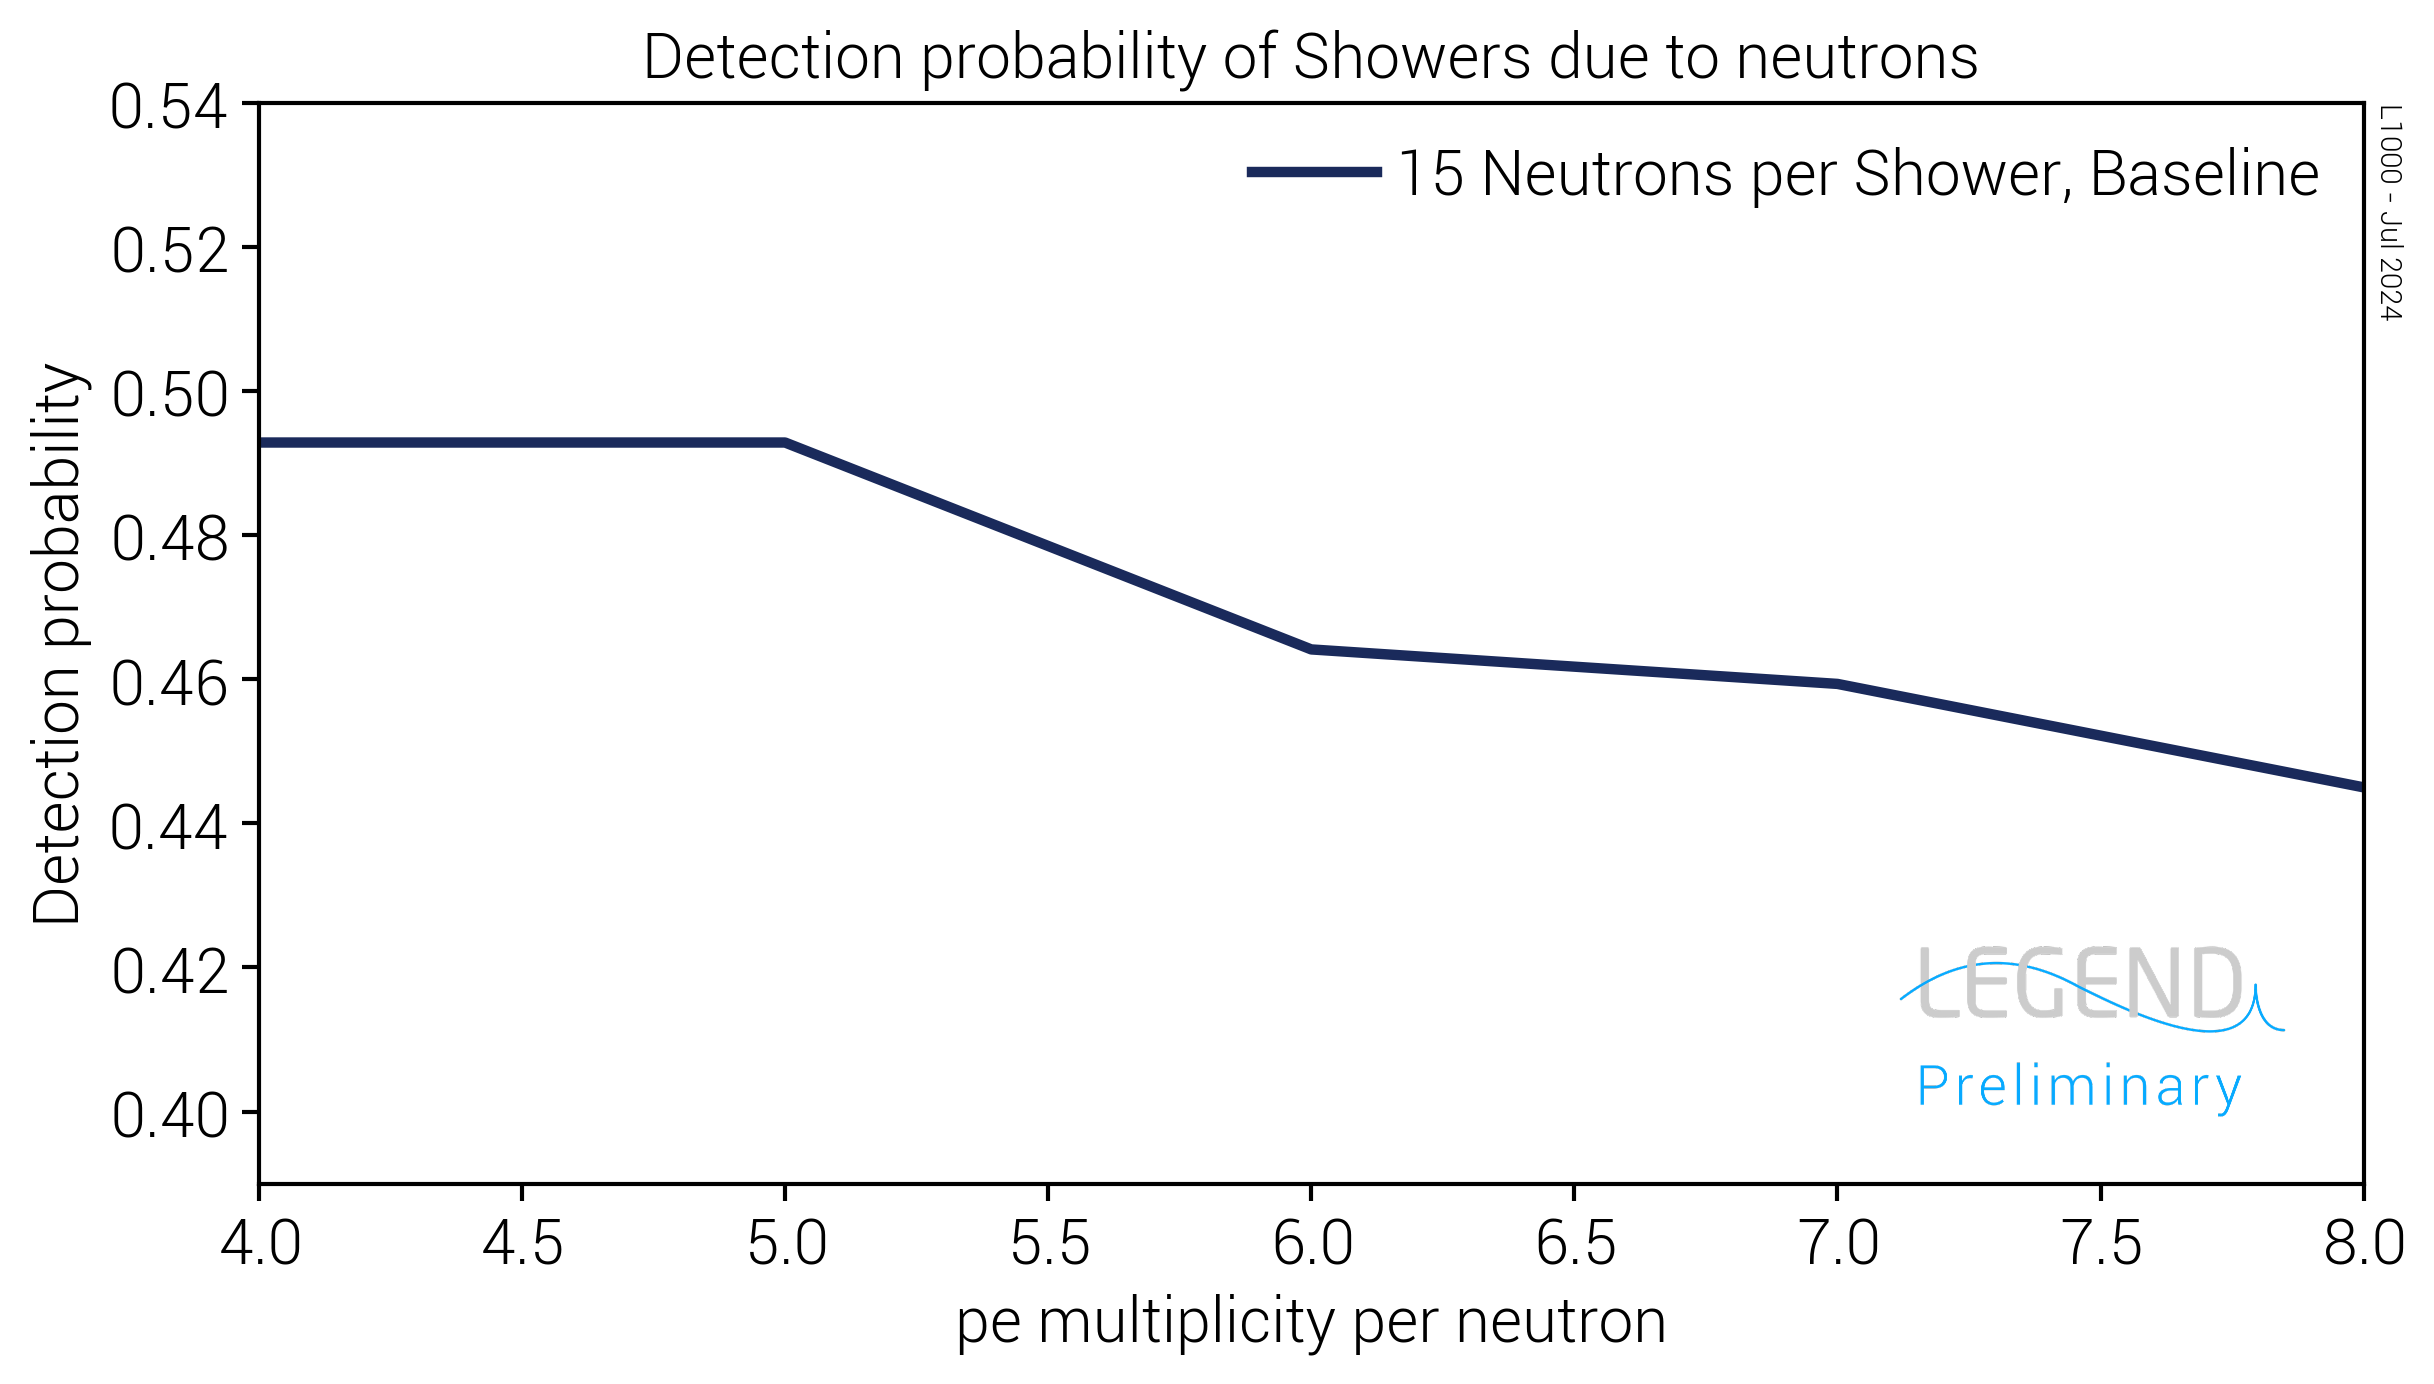

In [30]:
fig, ax1 = plt.subplots()

ax1.plot(multiplicitys, Detected_ShowersSetup1, color = lps.colors["legend_darkblue"], linewidth=2.5 ,  label="15 Neutrons per Shower, " + name1)



ax1.set_xlabel('pe multiplicity per neutron')
ax1.set_ylabel('Detection probability')
ax1.set_title('Detection probability of Showers due to neutrons')
ax1.set_xlim(xmin = 4, xmax= 8)
ax1.set_ylim(ymin = 0.39, ymax= 0.54)
#ax1.grid()



ax1.legend(loc='best')
ax1.set_legend_logo(position="lower right")
ax1.set_legend_annotation()
#plt.savefig("/home/eric/sim/WWLegend/Plots/LoadedScint/LoadedScintDetectionAllAndGe.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

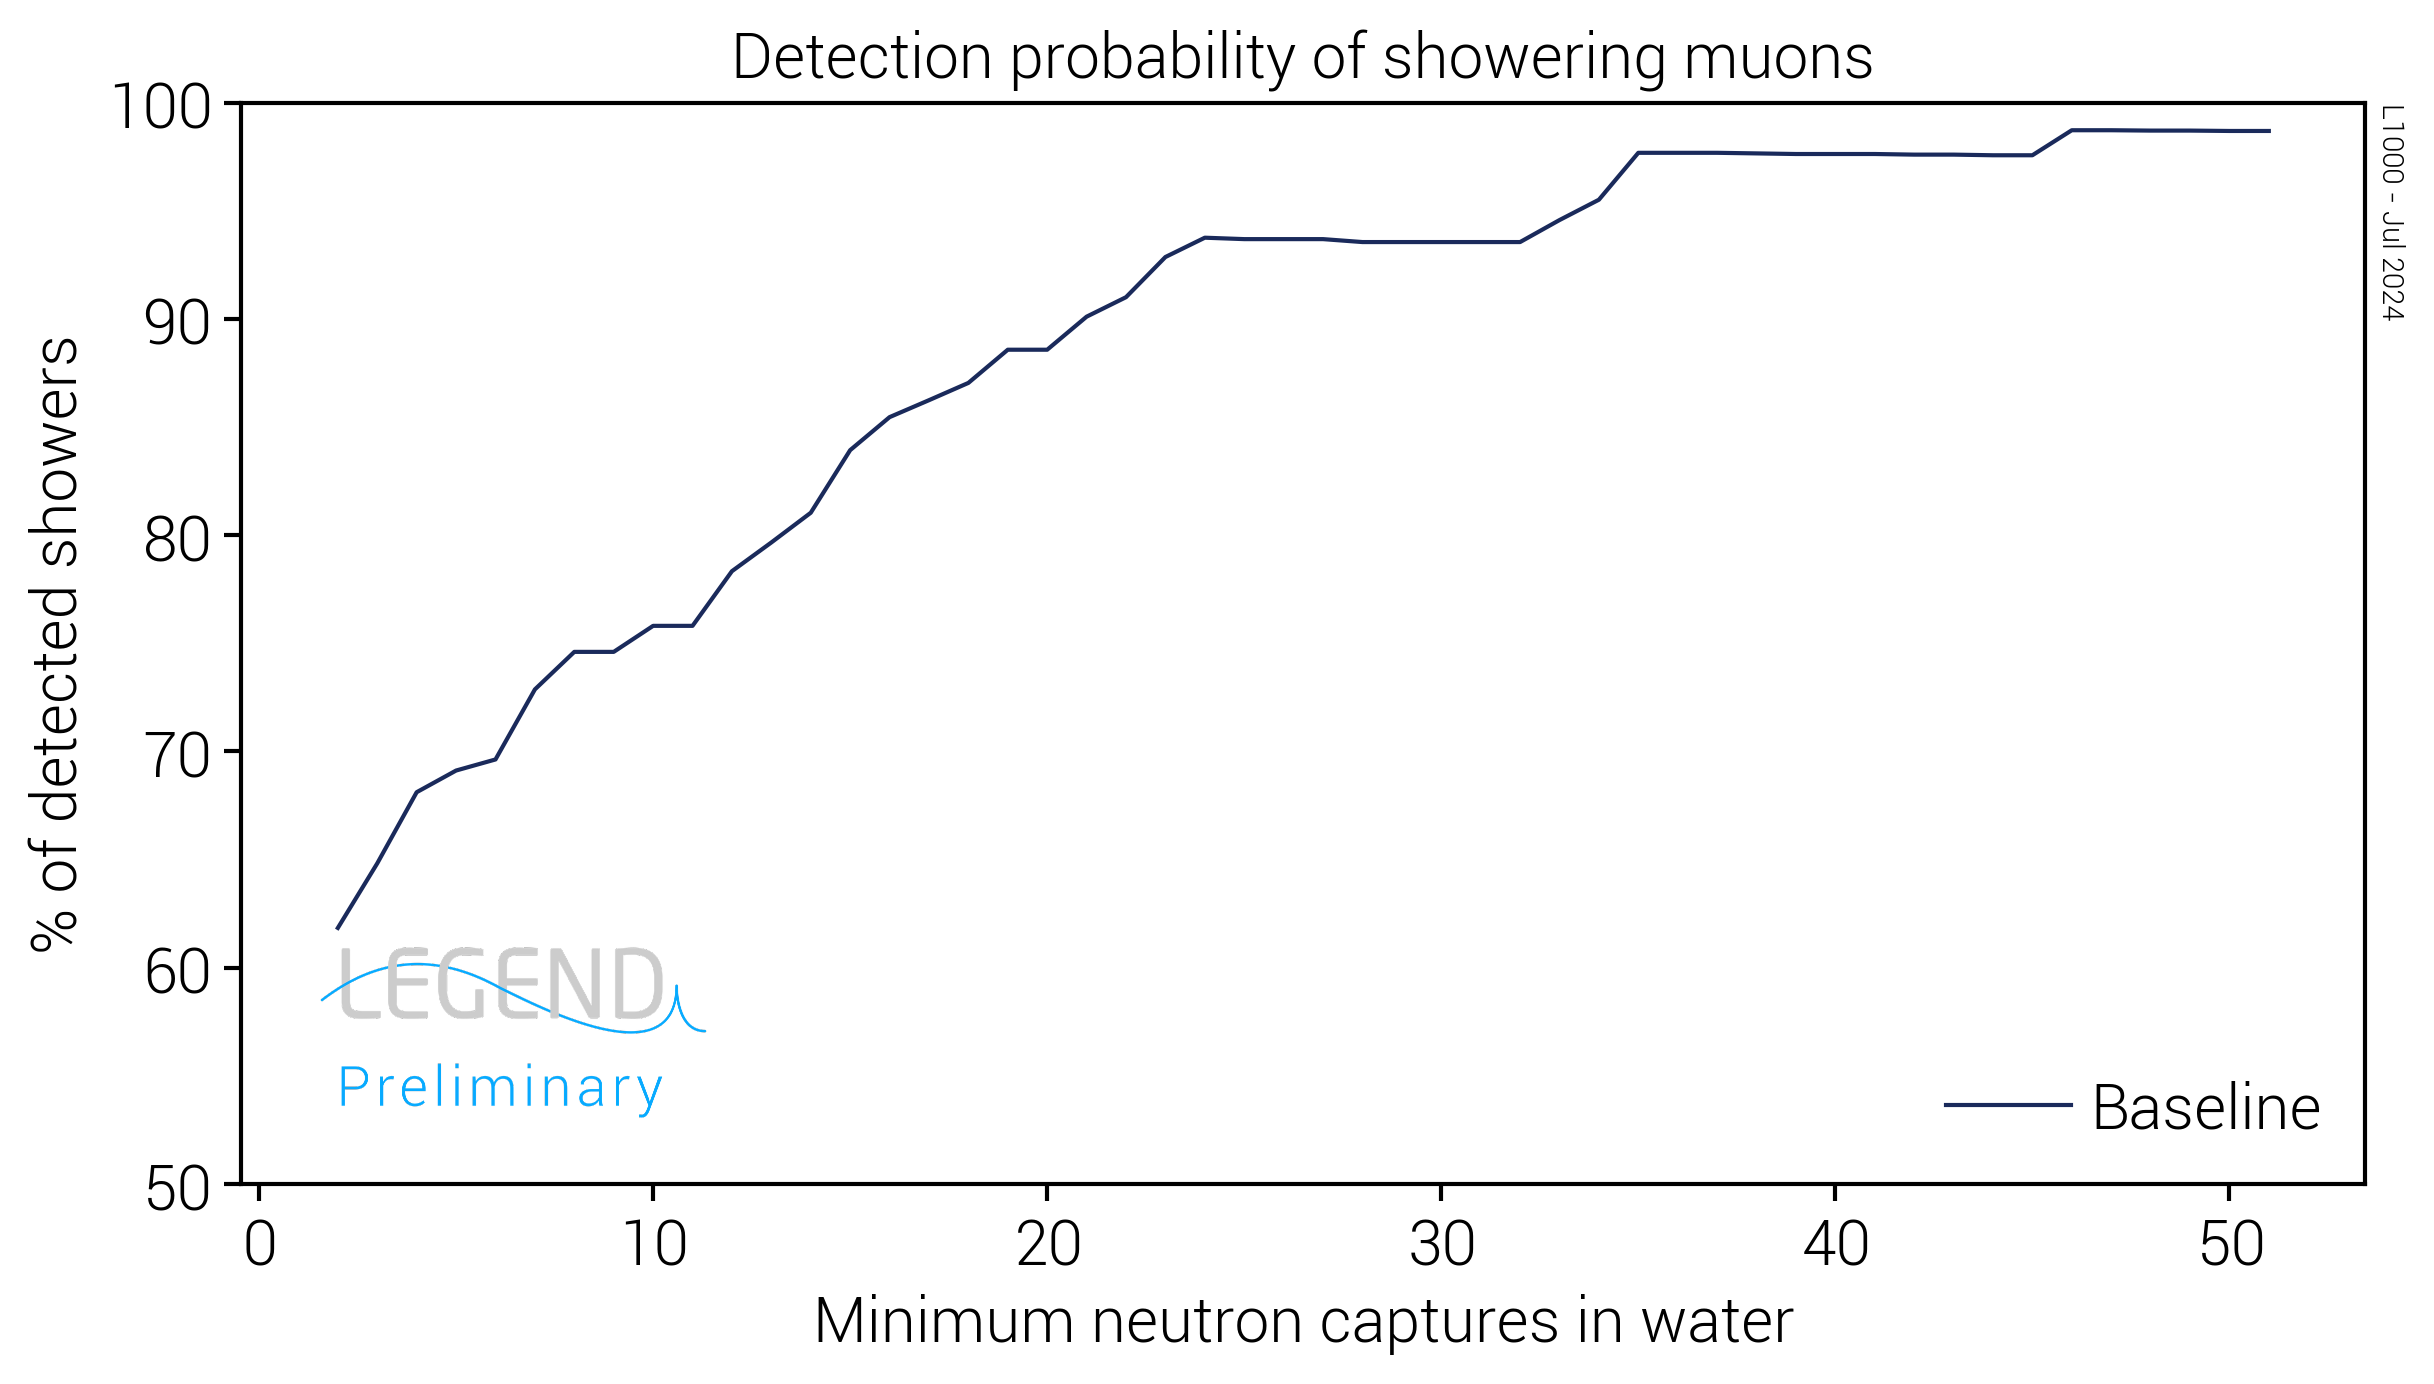

In [35]:
fig, ax1 = plt.subplots()
ax1.plot(neutrons_per_shower, WShowers_detectedSetup1*100,  color = lps.colors["legend_darkblue"], label = name1)


ax1.set_xlabel('Minimum neutron captures in water')
ax1.set_ylabel('% of detected showers')
ax1.set_title('Detection probability of showering muons')
ax1.set_ylim(ymin=50, ymax=100)
ax1.legend(loc="lower right")
ax1.set_legend_logo(position="lower left")
ax1.set_legend_annotation()
plt.tight_layout()
#plt.savefig("/home/eric/sim/WWLegend/Plots/LoadedScint/LoadedScintAverage_Showers_detected.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

Stuff to calculate the incident angle of the photons on the PMTs

In [10]:
#Import the file that also has the angles
timeSetup1, WavelengthsSetup1, PMTIDsSetup1, PhiPositionSetup1, xMomentumSetup1, yMomentumSetup1, zMomentumSetup1  = np.loadtxt(file_path + "Warwick with ArgonModerator/BaselineWithPMTs/BaselineWithPMTsAngleCalc.csv", dtype=float, skiprows=5, delimiter=',', unpack=True)

#Calculate the position unit polarvector from the phi
#Note: Phi is from -pi to pi!
# Convert phi array to unit vectors in cylindrical coordinates (z = 0)
unit_vectors = np.column_stack((np.cos(PhiPositionSetup1), np.sin(PhiPositionSetup1), np.zeros_like(PhiPositionSetup1)))

# Stack momentum components to form the momentum vectors array
momentum_vectors = np.column_stack((xMomentumSetup1, yMomentumSetup1, zMomentumSetup1))

# Calculate the scalar product for each pair of unit vector and momentum vector
scalar_products = np.einsum('ij,ij->i', unit_vectors, momentum_vectors)

print("Unit vectors in cylindrical coordinates:\n", unit_vectors)
print("Momentum vectors in Cartesian coordinates:\n", momentum_vectors)
print("Scalar products:\n", scalar_products)

print(np.size(PhiPositionSetup1))
print(np.size(scalar_products))


Unit vectors in cylindrical coordinates:
 [[-0.79242455 -0.60996994  0.        ]
 [-0.97923921  0.20270811  0.        ]
 [-0.99901791 -0.04430814  0.        ]
 ...
 [-0.94112189  0.33806742  0.        ]
 [-0.63022554  0.77641211  0.        ]
 [ 0.16118016  0.986925    0.        ]]
Momentum vectors in Cartesian coordinates:
 [[ 0.467563   0.883289   0.0344271]
 [ 0.659995  -0.679453  -0.320546 ]
 [ 0.889798  -0.18088   -0.418977 ]
 ...
 [ 0.987319   0.0637103  0.145405 ]
 [-0.399025  -0.829821  -0.390097 ]
 [ 0.802013  -0.484554   0.349261 ]]
Scalar products:
 [-0.90928814 -0.78402361 -0.88090968 ... -0.90764915 -0.39280732
 -0.34894988]
650685
650685


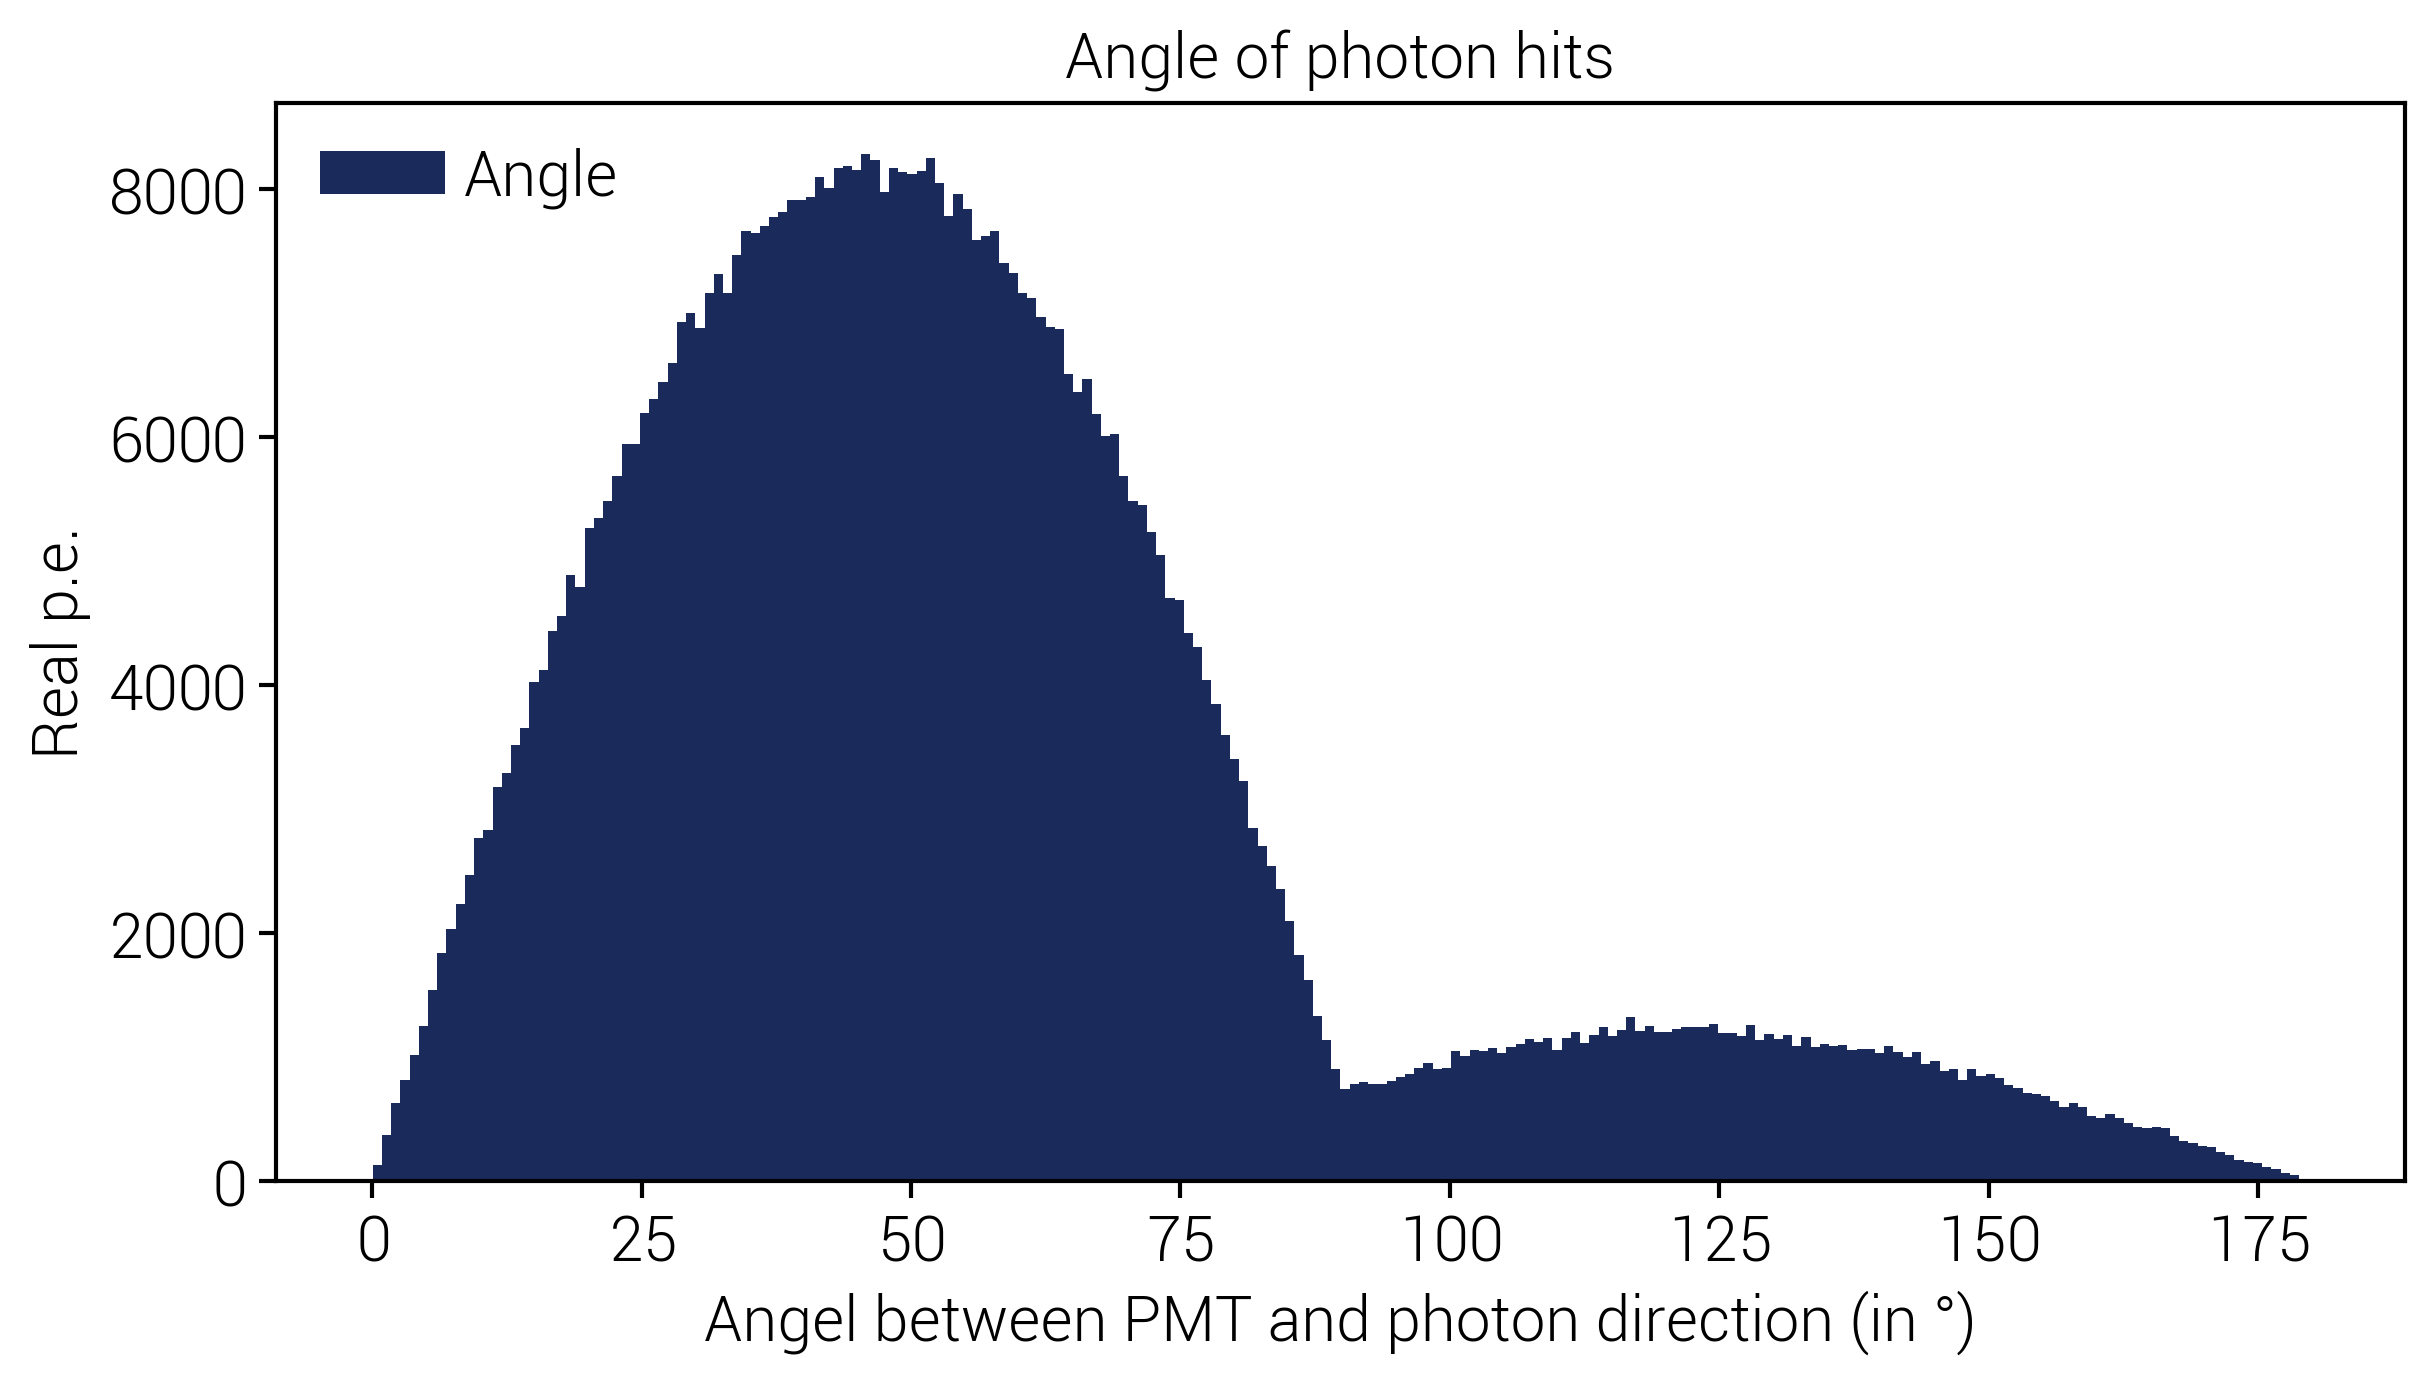

In [22]:
fig, ax1 = plt.subplots()
n, bins, patches = ax1.hist(np.arccos(-scalar_products)*360/(2*np.pi), color = lps.colors["legend_darkblue"], label= "Angle")

ax1.set_xlabel('Angel between PMT and photon direction (in °)')
ax1.set_ylabel('Real p.e.')
ax1.set_title('Angle of photon hits')
ax1.legend(loc= "upper left")
#ax1.grid()
#plt.savefig("/home/eric/sim/WWLegend/Plots/PMTsImplemented/Angle.png")
plt.show()